# TIME TRAVEL, support for debugging 

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=1.0, google_api_key = GOOGLE_API_KEY)

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [6]:
def multiply(a,b):
    ''' Multiple two numbers
    Agrs
    a: first int
    b: second int
    '''
    return a*b

def divide(a, b):
    ''' Divide two numbers
    Args
    a: first int
    b: second int
    '''
    return a/b

def add(a,b):
    ''' Add two numbers
    Args
    a: first int
    b: second int
    '''
    return a+b

tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

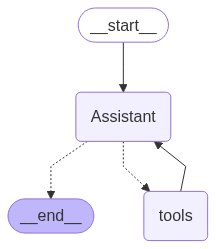

In [8]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    
sys_message = SystemMessage(content = 'You are a helpful assistant tasked with performing arithmetic on a set of inputs')

def llm_call(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_message] +state['messages'])]}
    
builder = StateGraph(MessagesState)
builder.add_node('Assistant', llm_call)
builder.add_node('tools', ToolNode(tools))

# LOGIC
builder.add_edge(START, 'Assistant')
builder.add_conditional_edges('Assistant', tools_condition)
builder.add_edge('tools', 'Assistant')

memory = MemorySaver()

graph = builder.compile(checkpointer = memory)
graph

In [9]:
initial_input = {'messages' : 'Multiple 2 and 6'}

thread = {'configurable': {'thread_id' : 1}}

for event in graph.stream(initial_input, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiple 2 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (9ac2b135-7286-46c0-ae17-6c8c3420fb4c)
 Call ID: 9ac2b135-7286-46c0-ae17-6c8c3420fb4c
  Args:
    b: 6.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

12.0
================================== Ai Message ==================================

The answer is 12.


In [10]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiple 2 and 6', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 6.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--367ab16a-0207-4b50-847d-1e91f15e4620-0', tool_calls=[{'name': 'multiply', 'args': {'b': 6.0, 'a': 2.0}, 'id': '9ac2b135-7286-46c0-ae17-6c8c3420fb4c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 5, 'total_tokens': 89, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='12.0', name='multiply', id='4ca8455c-5f7e-457c-a271-cd4a429cf227', tool_call_id='9ac2b135-7286-46c0-ae17-6c8c3420fb4c'), AIMessage(content='The answer is 12.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reas

In [13]:
all_states = graph.get_state_history(thread)

In [15]:
st = [s for s in all_states]

In [20]:
st[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiple 2 and 6', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}, next=('Assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa7-649e-8000-bb4de990e133'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': 1}, created_at='2025-06-11T04:06:11.471675+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa0-6400-bfff-f9851fcf77fe'}}, tasks=(PregelTask(id='4ea7d854-0d8c-9cf8-d1e0-8741b9b84b4a', name='Assistant', path=('__pregel_pull', 'Assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 6.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-

# WE CAN REPLAY AGENT FROM ANY OF ITS PRIOR STEPS

### Replay is different from re-execute, To replay from a cretain checkpoint, give thread and checkpointid in graph.stream

In [25]:
to_replay = st[-2]
to_replay.values

{'messages': [HumanMessage(content='Multiple 2 and 6', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}

In [30]:
checkpoint_id = to_replay.config

In [31]:
for event in graph.stream(None, checkpoint_id, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiple 2 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (72b9a299-ceb0-4dfe-969b-a9a0f4bc517b)
 Call ID: 72b9a299-ceb0-4dfe-969b-a9a0f4bc517b
  Args:
    b: 6.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

12.0
================================== Ai Message ==================================

The answer is 12.


# FORKING, when you are doing graph.update() you are forking the current state, adding a new checkpoint to the history


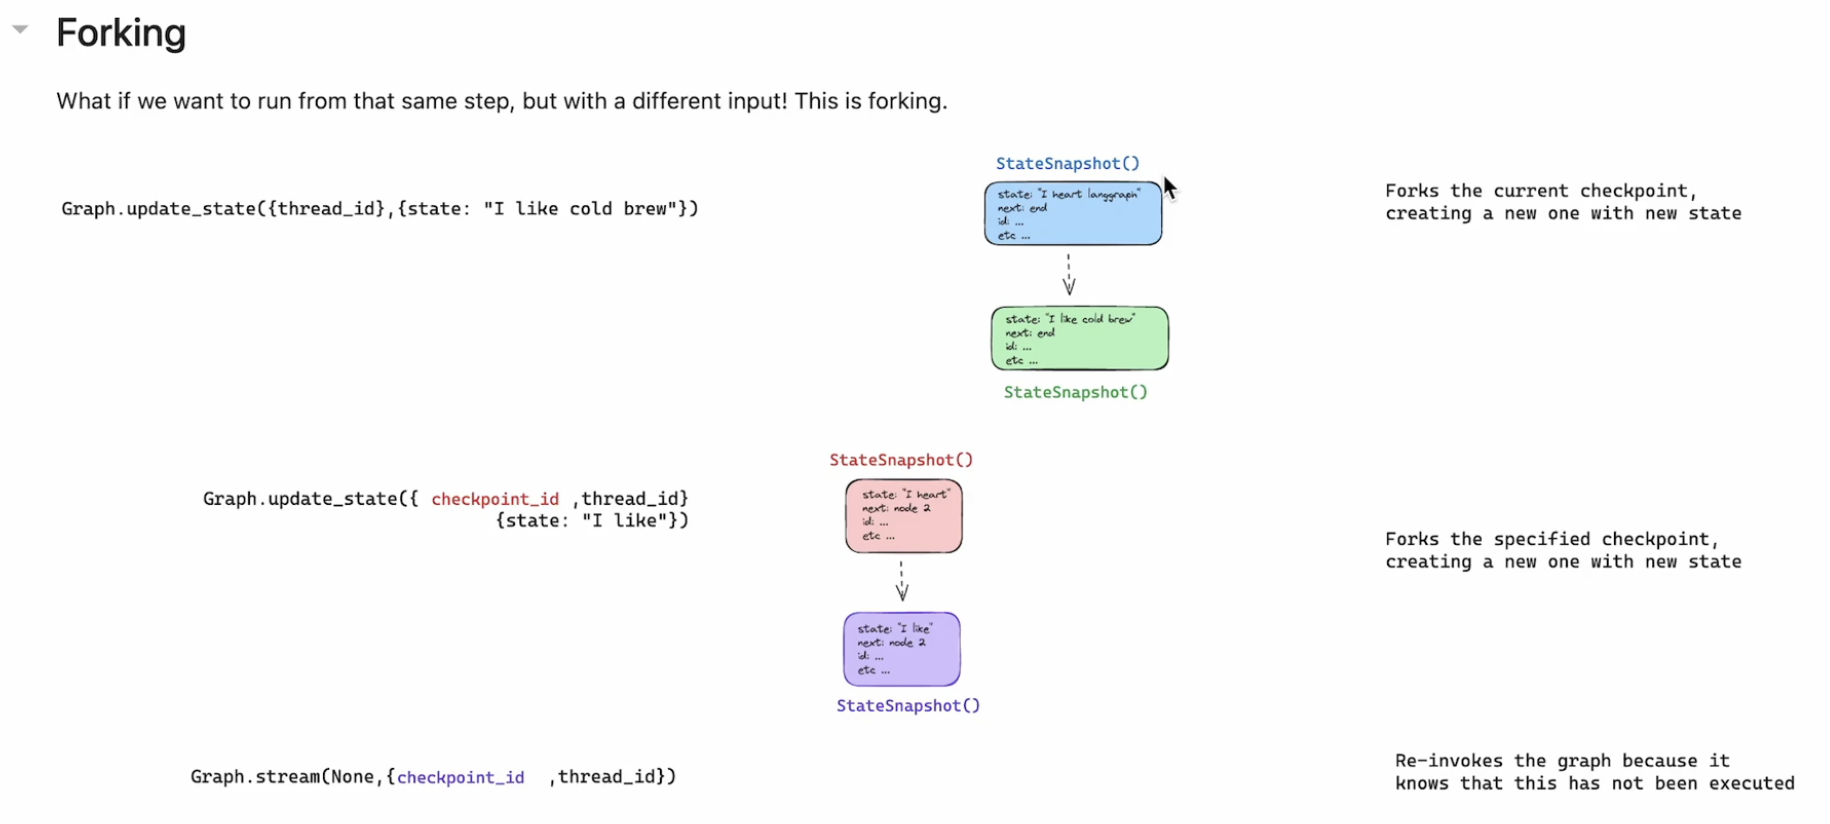

The last one is an example of reexecuting, once you create an update on a checkpoint and do graph.stream(None, checkpointid, mode), we never executed this part, so langgraph will execute it now

In [32]:
to_fork = st[-2]
to_fork

StateSnapshot(values={'messages': [HumanMessage(content='Multiple 2 and 6', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}, next=('Assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa7-649e-8000-bb4de990e133'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': 1}, created_at='2025-06-11T04:06:11.471675+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa0-6400-bfff-f9851fcf77fe'}}, tasks=(PregelTask(id='4ea7d854-0d8c-9cf8-d1e0-8741b9b84b4a', name='Assistant', path=('__pregel_pull', 'Assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 6.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-

In [34]:
to_fork.values

{'messages': [HumanMessage(content='Multiple 2 and 6', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}

In [33]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f046796-8fa7-649e-8000-bb4de990e133'}}

### The update_state uses the reducer function for a state key. Ideally, add_message reducer adds to an existing list but in this case, when we provide an id, we override a message with a particular id

In [37]:
from langchain_core.messages import HumanMessage
fork_config = graph.update_state(
    to_fork.config,
    {'messages': [HumanMessage(content = 'Multiply 5 and 10', id = to_fork.values['messages'][0].id)]}
)

In [38]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0468e4-8878-6930-8001-92a0fe184b5d'}}

In [39]:
all_states = [s for s in graph.get_state_history(thread)]

In [40]:
len(all_states)

9

In [43]:
for s in all_states:
    print(s)
    print()

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 10', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}, next=('Assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0468e4-8878-6930-8001-92a0fe184b5d'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 10', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa7-649e-8000-bb4de990e133'}, created_at='2025-06-11T06:35:36.462736+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046796-8fa7-649e-8000-bb4de990e133'}}, tasks=(PregelTask(id='07c1fe51-924f-bba1-a8e6-2fa7dba85579', name='Assistant', path=('__pregel_pull', 'Assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

S

In [44]:
for event in graph.stream(None, fork_config, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 10
================================== Ai Message ==================================
Tool Calls:
  multiply (3b94217e-8365-4f32-bdca-b236585f3132)
 Call ID: 3b94217e-8365-4f32-bdca-b236585f3132
  Args:
    b: 10.0
    a: 5.0
================================= Tool Message =================================
Name: multiply

50.0
================================== Ai Message ==================================

5 multiplied by 10 is 50.


In [45]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 10', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 10.0, "a": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c624eda6-e2e2-4d88-b2e8-08dd45e56088-0', tool_calls=[{'name': 'multiply', 'args': {'b': 10.0, 'a': 5.0}, 'id': '3b94217e-8365-4f32-bdca-b236585f3132', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 5, 'total_tokens': 90, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='50.0', name='multiply', id='dbd2e588-143a-49dd-ac0a-218f8ca56d7c', tool_call_id='3b94217e-8365-4f32-bdca-b236585f3132'), AIMessage(content='5 multiplied by 10 is 50.', additional_kwargs={}, response_metadata={'prompt_feedback': {

In [62]:
new_history = graph.get_state_history(thread)

In [63]:
new_history

<generator object Pregel.get_state_history at 0x113dce820>

In [64]:
history_array = [e for e in new_history]

In [65]:
for e in history_array:
    print(e)
    print()

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 10', additional_kwargs={}, response_metadata={}, id='23edf2f6-c171-4711-a3d6-4f4617cd2378'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 10.0, "a": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c624eda6-e2e2-4d88-b2e8-08dd45e56088-0', tool_calls=[{'name': 'multiply', 'args': {'b': 10.0, 'a': 5.0}, 'id': '3b94217e-8365-4f32-bdca-b236585f3132', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 5, 'total_tokens': 90, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='50.0', name='multiply', id='dbd2e588-143a-49dd-ac0a-218f8ca56d7c', tool_call_id='3b94217e-8365-4f32-bdca-b236585f3132'), AIMessage(content='5 multiplied by 10 is 50.', additional_kwargs={}, response_metadata={'prompt_feedback': {